参考pinard博客文章：http://www.cnblogs.com/pinard/p/6056319.html

## 1. sklearn.tree中的DecisionTreeClassifier方法参数：

### 1.1 基本参数

+ **criterion**: The function to measure the quality of a split.支持基尼指数(gini)和信息增益(entropy)。默认选择基尼指数，即CART算法。在C4.5和ID3  中使用的是信息增益准则。
+ **spliter**:  The strategy used to choose the split at each node. 有best和random两种选择,默认是best。best在所有的切分点中找出最优的切分点， random在随机的部分切分点中找出局部最优切分点。best适合样本量较小的情况，样本量较大时，应使用random。


### 1.2 限制树的生长

+ **max_depth**: 决策树最大深度，默认None，即不加限制。一般来说，数据少或者特征少的时候可以不管这个值。如果模型样本量多，特征也多的情况下，推荐限制这个最大深度，具体的取值取决于数据的分布。常用的可以取值10-100之间。
+ **min_samples_split**: 节点需要继续切分的最小样本数，默认为2.可以是整数或者小数。如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。我之前的一个项目例子，有大概10万样本，建立决策树时，我选择了min_samples_split=10。可以作为参考。
+ **min_impurity_decrease**: 最小不纯度下降切分，小数，默认为0. 即节点被切分后，不纯度下降量超过了这个值，则进行切分，否则不切分。
+ **min_impurity_split**:最小不纯度切分。当节点的不纯度小于这个阈值时，树停止生成。注意，在0.21版本后将不再支持，使用min_impurity_decrerase代替。

### 1.3 防止过拟合

+ **max_leaf_nodes**:最大叶子节点个数，默认是None，即不限制。算法会在最大叶子节点的限制下生成最优的决策树。可以防止过拟合。具体的值可以通过交叉验证得到。
+ **min_samples_leaf**: 节点称为叶子节点所需的最小样本数，默认是1.可以是整数或者小数。如果叶子节点样本数没有达到这个值，则它和兄弟节点都将被将减掉。如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。之前的10万样本项目使用min_samples_leaf的值为5，仅供参考。
+ **min_weight_fraction_leaf**:这个值限制了叶子节点所有样本权重和的最小值，如果小于这个值，则会和兄弟节点一起被剪枝。 默认是0，就是不考虑权重问题。一般来说，如果我们有较多样本有缺失值，或者分类树样本的分布类别偏差很大，就会引入样本权重，这时我们就要注意这个值了.


### 1.4 生成速度

+ **max_features**: 切分时考虑的最大特征数，默认是None，即全部考虑。一般来说，当特征数小于50时，使用None就可以，当特征数较大时，应该考虑适当的取值以控制决策树生成的时间。
+ **presort**:数据是否需要与排序来加速最优切分的寻找。布尔值，默认为False。样本量较小或者限制树深度时，可以加速训练。


## 2. 经验
1）当**样本少数量但是样本特征非常多**的时候，决策树很容易过拟合，一般来说，样本数比特征数多一些会比较容易建立健壮的模型。  
样本数量少而特征数量大时，样本无法刻画数据的真实分布。  
一般来说，一个特征需要几十个样本来估计其分布，特征量增大时，需要的样本数是呈指数增加的。


2）如果样本数量少但是样本特征非常多，在拟合决策树模型前，推荐先做维度规约，比如主成分分析（PCA），特征选择（Losso）或者独立成分分析（ICA）。这样特征的维度会大大减小。再来拟合决策树模型效果会好。


3）推荐多用决策树的可视化（下节会讲），同时先限制决策树的深度（比如最多3层），这样可以先观察下生成的决策树里数据的初步拟合情况，然后再决定是否要增加深度。


4）在训练模型先，注意观察样本的类别情况（主要指分类树），如果**类别分布非常不均匀**，就要考虑用class_weight来限制模型过于偏向样本多的类别。


5）决策树的数组使用的是numpy的float32类型，如果训练数据不是这样的格式，算法会先做copy再运行。


6）如果输入的样本矩阵是稀疏的，推荐在拟合前调用csc_matrix稀疏化，在预测前调用csr_matrix稀疏化。


## 3. 决策树可视化

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.datasets import load_iris
import sys
import os
from IPython.display import Image

iris = load_iris()
dtc = DecisionTreeClassifier()
dtc.fit(iris.data,iris.target)



DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

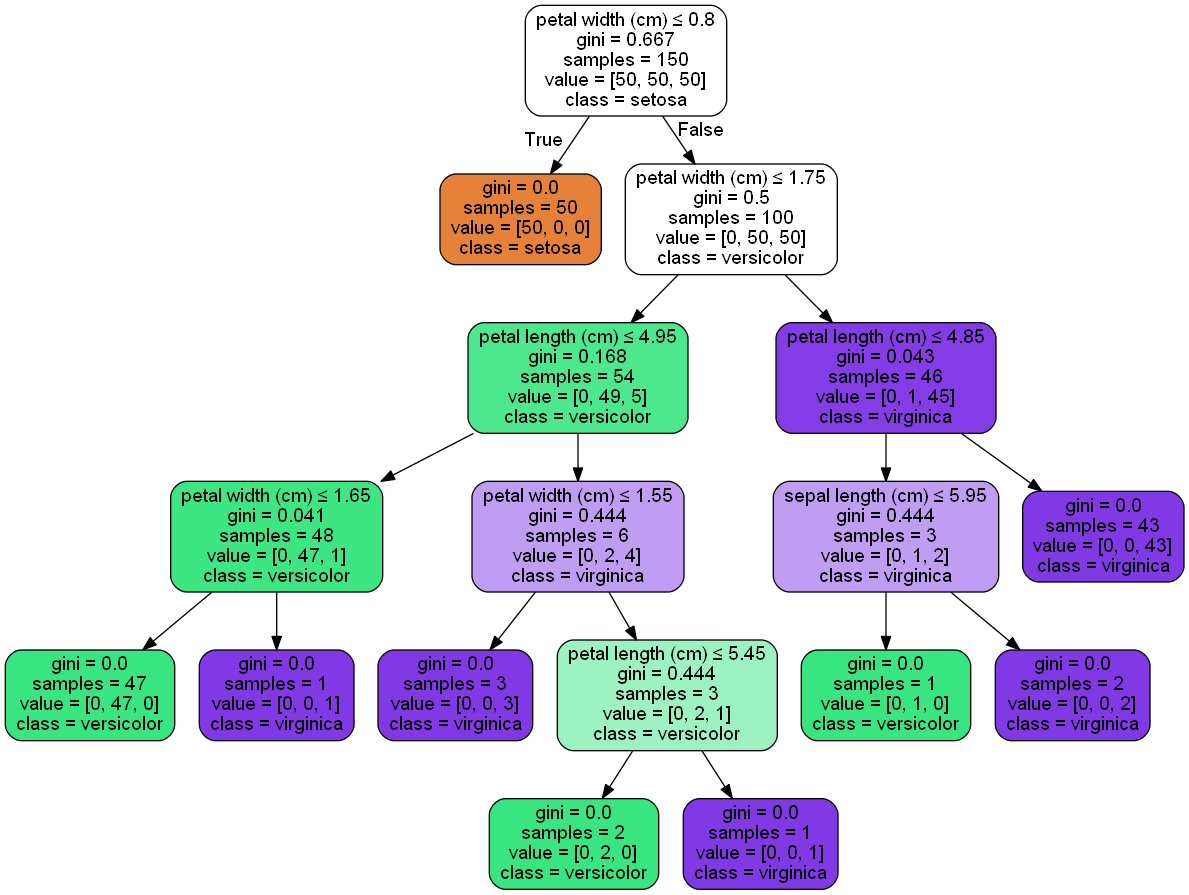

In [4]:

import pydotplus
import graphviz
dot_data = tree.export_graphviz(dtc,out_file = None,feature_names=iris.feature_names,class_names=iris.target_names, filled=True, rounded=True,  
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## 4. 几个重要的函数

1. np.meashgrid  根据向量生成网格
2. np.c\_\[a,b\]  列主元拼接,np.r_行主元拼接。
3. a.ravel(order)  将矩阵将到一维，等价于reshape(-1, order=order)
4. a.reshape(newshape,order) 按照order读和写 
5. numpy.reshape(a,newshape,order) 等价于 a.reshape(newshape,order)
6. order ={'C’,'F','K'}

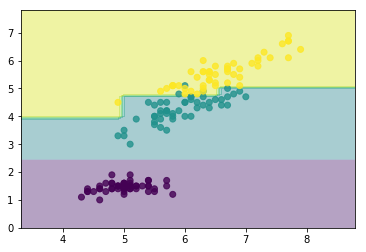

In [30]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier

iris = datasets.load_iris()
x = iris.data[:,[0,2]]
y = iris.target

dtc = DecisionTreeClassifier(max_depth=4)
dtc.fit(x,y)
x1_min,x1_max = x[:,0].min()-1,x[:,0].max()+1
x2_min,x2_max = x[:,1].min()-1,x[:,1].max()+1

xx,yy = np.meshgrid(np.arange(x1_min,x1_max,0.1),
                   np.arange(x2_min,x2_max,0.1))
z = dtc.predict(np.c_[xx.ravel(),yy.ravel()])
z = z.reshape(xx.shape)

plt.contourf(xx, yy, z, alpha=0.4)
plt.scatter(x[:, 0], x[:, 1], c=y, alpha=0.8)
plt.show()